In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Problem : Principal Component Analysis
**Principal component analysis** (PCA) is a technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

In [5]:
X_train,X_test=[],[]
Y_train,Y_test=[],[]
for i in range(1,41): #共40個人
    for j in range(1,10): #只讀前九筆資料, 因為第十筆要當作Y_test
        img=cv2.imread('data/{}_{}.png'.format(i,j),cv2.IMREAD_GRAYSCALE) #讀成灰階的模式
        X_train.append(img)
        Y_train.append(i)
    #第十筆當作test
    img=cv2.imread('data/{}_10.png'.format(i),cv2.IMREAD_GRAYSCALE)
    X_test.append(img)
    Y_test.append(i)
        
X_train=np.array(X_train)
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(360, 56, 46) (360,)
(40, 56, 46) (40,)


In [7]:
x=X_train.reshape(len(Y_train),-1) #有將所有資料留下,但都變成一維的, 56x46
print(x.shape)

(360, 2576)


## 1. mean face & first four eigenfaces

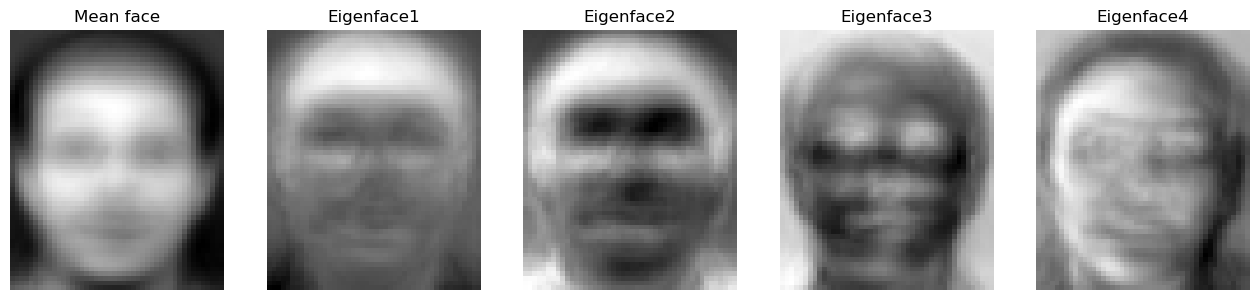

In [9]:
pca=PCA()
pca.fit(X_train.reshape(len(Y_train),-1))

plt.figure(figsize=(16,12))
plt.subplot(1,5,1) #如果要看五個就是改成 (1,6,1)
plt.axis('off')
plt.title('Mean face')
#要再reshape回二維的圖
plt.imshow(pca.mean_.reshape(X_train[0].shape),cmap='gray')

for i in range(4): #畫前四個
    plt.subplot(1,5,i+2) #因為原本已經有一個, 所以i+2, 如果要看五個就是改成 (1,6,i+2)
    plt.axis('off')
    plt.title('Eigenface{}'.format(i+1))
    plt.imshow(pca.components_[i].reshape(X_train[0].shape),cmap='gray')
    
plt.show()

In [12]:
pca.components_

array([[-0.00606884, -0.00622373, -0.00559664, ..., -0.015444  ,
        -0.01280517, -0.01320866],
       [-0.02919239, -0.0292641 , -0.02943494, ...,  0.01436437,
         0.01924303,  0.01866536],
       [ 0.04056566,  0.04046655,  0.04069564, ...,  0.02404566,
         0.02869245,  0.03064081],
       ...,
       [-0.00480933,  0.00458813, -0.00357631, ..., -0.00670399,
         0.00157123, -0.01541276],
       [-0.01232153, -0.00910163, -0.01310147, ...,  0.0151012 ,
        -0.00543541, -0.00570998],
       [ 0.02634379, -0.0008757 ,  0.0282131 , ..., -0.00806645,
         0.00647468,  0.00541139]])

In [13]:
pca.components_.shape

(360, 2576)

## 2. Reconstruct person2 image1 using the first n = 3, 50, 170, 240, 345 eigenfaces
## 3. compute the mean squared error

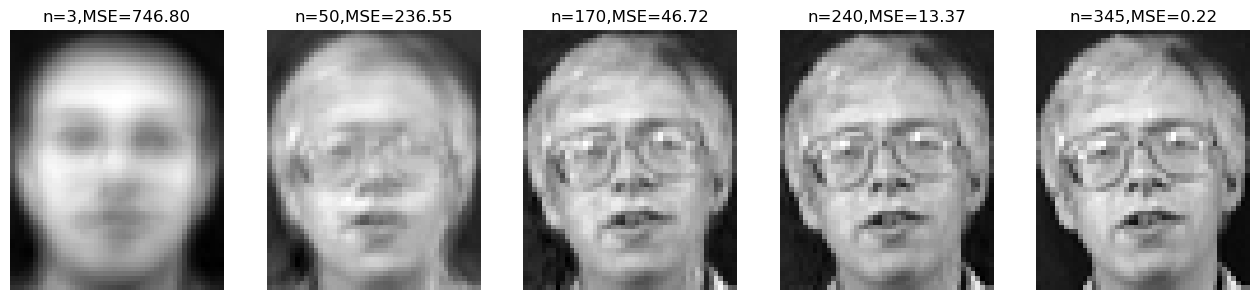

In [16]:
#指定要看第二個人image1
img=cv2.imread('data/2_1.png',cv2.IMREAD_GRAYSCALE).reshape(1,-1)
a=pca.transform(img)

plt.figure(figsize=(16,12))
n_components=[3,50,170,240,345]
for i,n in enumerate(n_components):  #此時i會是0,1,2,3,4 而n會是3,50,170,240,345
    face=np.zeros(img.shape) #先生成一個黑色的圖
    for j in range(n):
        face=face+a[0][j]*pca.components_[j] #pca.components_[j]就是pca重建後的影像, 也就是乘一個係數回來
    face=face+pca.mean_
    MSE=np.mean((face-img)**2)
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.title('n={},MSE={:.2f}'.format(n,MSE))
    plt.imshow(face.reshape(X_train[0].shape),cmap='gray')

## 4. cross-validation results

In [19]:
#介紹np.random.permutation
a=np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
#加了np.random.permutation後, a就會變成~打亂的
a=np.random.permutation(np.arange(10))
a

array([7, 8, 6, 9, 4, 5, 1, 3, 2, 0])

In [22]:
reduced_X_train=pca.transform(X_train.reshape(len(Y_train),-1))
K=[1,3,5]
N=[3,50,170]
random=np.random.permutation(len(Y_train)) #打亂Y_train
reduced_X_train=reduced_X_train[random]
Y_train_random=Y_train[random]

for k in K:
    print('k={}'.format(k))
    knn=KNeighborsClassifier(n_neighbors=k)
    for n in N:
        print('  n={}'.format(n),end='')
        score=cross_val_score(knn,reduced_X_train[:,:n],Y_train_random,cv=3) #切成n筆資料, cv=3, cross validation分成三組
        print('score={:.4f}'.format(score.mean()))

k=1
  n=3score=0.6972
  n=50score=0.9722
  n=170score=0.9722
k=3
  n=3score=0.6278
  n=50score=0.9194
  n=170score=0.8972
k=5
  n=3score=0.5778
  n=50score=0.8500
  n=170score=0.8528


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

## 5. recognition rate of the testing set

In [23]:
#拿上面分數最高的k=1,n=50

k=1
n=50

reduced_X_test=pca.transform(X_test.reshape(len(Y_test),-1))
knn=KNeighborsClassifier(n_neighbors=k)
knn.fit(reduced_X_train[:,:n],Y_train_random)

print('accuracy={}'.format(knn.score(reduced_X_test[:,:n],Y_test)))

accuracy=0.925


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
